In [1]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
import pingouin as pg

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Importamos los datos a usar
#=====================================
datos = pd.read_csv(r'C:\Users\andrea\Documents\Kevin - Data Science\Mi corte 04\LABS\Proyecto Grupal\Datasets-20221115T003944Z-001\Datasets\Datasets cargados en el DB\Housing_macroeconomic_factors_EDA.csv')
datos.head()

,Date,house_price_index,population,gdp,mortgage_rate,employment_rate,ppi_res,m3,cci,delinquency_rate,hcai
0,1987-01-01,63.965,241857,-0.046873,9.2040,70.163085,100.0,2.7439,100.4624,3.984947,8.981895
1,1987-02-01,64.424,242005,-0.070868,9.0825,70.289205,100.4,2.7475,100.4945,3.984947,8.981895
2,1987-03-01,64.735,242166,-0.076326,9.0350,70.321678,100.7,2.7537,100.5720,3.984947,8.981895
3,1987-04-01,65.132,242338,-0.065327,9.8325,70.499062,101.1,2.7677,100.6568,3.984947,8.981895
4,1987-05-01,65.565,242516,-0.040144,10.5960,70.808308,101.3,2.7729,100.6919,3.984947,8.981895


In [3]:
# Correlación entre columnas numéricas
# ==============================================================================

def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matriz de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)



corr_matrix = datos.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

,variable_1,variable_2,r,abs_r
15,population,ppi_res,0.961313,0.961313
51,ppi_res,population,0.961313,0.961313
31,mortgage_rate,population,-0.959801,0.959801
13,population,mortgage_rate,-0.959801,0.959801
65,m3,ppi_res,0.956496,0.956496
56,ppi_res,m3,0.956496,0.956496
60,m3,house_price_index,0.925596,0.925596
6,house_price_index,m3,0.925596,0.925596
50,ppi_res,house_price_index,0.924660,0.924660
5,house_price_index,ppi_res,0.924660,0.924660


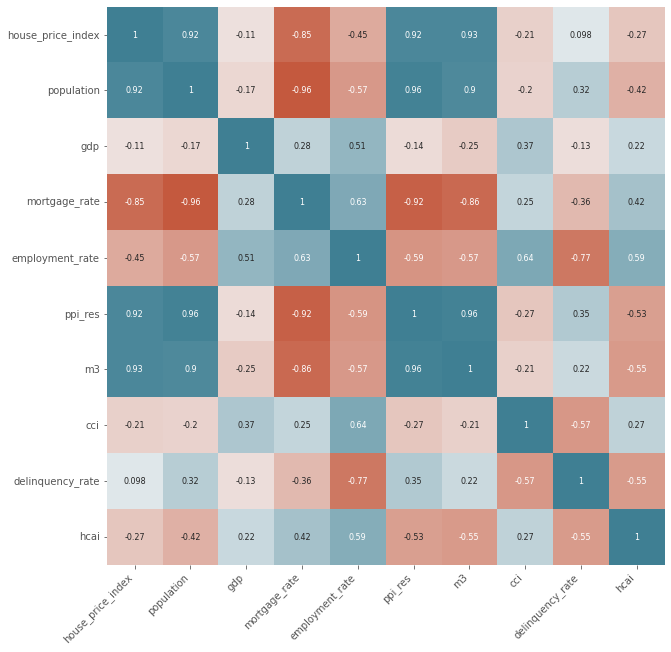

In [4]:
# Heatmap matriz de correlaciones
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 15))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)

In [5]:
# División de los datos en train y test
# ==============================================================================
X = datos[['population', 'gdp', 'mortgage_rate','ppi_res','m3','cci','delinquency_rate','hcai']]
y = datos['house_price_index']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.3,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [6]:
# Creación del modelo 
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     512.6
Date:                Mon, 28 Nov 2022   Prob (F-statistic):           2.84e-87
Time:                        20:12:58   Log-Likelihood:                -453.42
No. Observations:                 126   AIC:                             924.8
Df Residuals:                     117   BIC:                             950.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              376.4357     87.210  

El modelo con todas las variables introducidas como predictores tiene un  R2  alto (0.972), es capaz de explicar el 97.2% de la variabilidad observada en el indice de precios de la vivienda. 


Acorde al p-value obtenido para el coeficiente parcial de regresión de ppi_res (indice de precios al productor) (0.693), esta variable no contribuye de forma significativa al modelo. Se entrena de nuevo el modelo, pero esta vez excluyendo el predictor ppi_res que es indice de precios al productor.

In [7]:
# Creación del modelo utilizando matrices
# ==============================================================================
# Se elimina la columna ppi_res del conjunto de train y test
X_train = X_train.drop(columns = 'ppi_res')
X_test  = X_test.drop(columns = 'ppi_res')

#Corremos el modelo nuevamente
#====================================================
X_train = sm.add_constant(X_train, prepend=True)
modelo  = sm.OLS(endog=y_train, exog=X_train,)
modelo  = modelo.fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     590.0
Date:                Mon, 28 Nov 2022   Prob (F-statistic):           1.22e-88
Time:                        20:12:58   Log-Likelihood:                -453.51
No. Observations:                 126   AIC:                             923.0
Df Residuals:                     118   BIC:                             945.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              367.0308     83.616  

In [9]:
# Diagnóstico errores (residuos) de las predicciones de entrenamiento
# ==============================================================================
y_train = y_train.flatten()
prediccion_train = modelo.predict(exog = X_train)
residuos_train   = prediccion_train - y_train

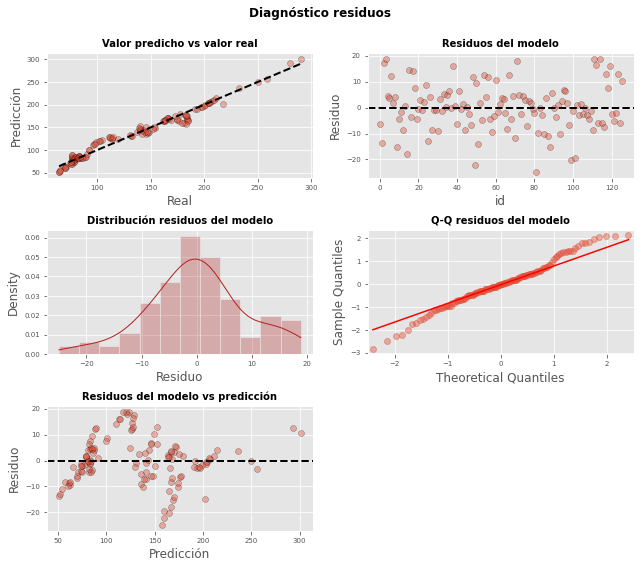

In [10]:
# Gráficos
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 8))

axes[0, 0].scatter(y_train, prediccion_train, edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
                'k--', color = 'black', lw=2)
axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Predicción')
axes[0, 0].tick_params(labelsize = 7)

axes[0, 1].scatter(list(range(len(y_train))), residuos_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[0, 1].set_title('Residuos del modelo', fontsize = 10, fontweight = "bold")
axes[0, 1].set_xlabel('id')
axes[0, 1].set_ylabel('Residuo')
axes[0, 1].tick_params(labelsize = 7)

sns.histplot(
    data    = residuos_train,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[1, 0]
)

axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 10,
                     fontweight = "bold")
axes[1, 0].set_xlabel("Residuo")
axes[1, 0].tick_params(labelsize = 7)


sm.qqplot(
    residuos_train,
    fit   = True,
    line  = 'q',
    ax    = axes[1, 1], 
    color = 'firebrick',
    alpha = 0.4,
    lw    = 2
)
axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 10, fontweight = "bold")
axes[1, 1].tick_params(labelsize = 7)

axes[2, 0].scatter(prediccion_train, residuos_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[2, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize = 10, fontweight = "bold")
axes[2, 0].set_xlabel('Predicción')
axes[2, 0].set_ylabel('Residuo')
axes[2, 0].tick_params(labelsize = 7)

# Se eliminan los axes vacíos
fig.delaxes(axes[2,1])

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Diagnóstico residuos', fontsize = 12, fontweight = "bold");

Test de normalidad


Se comprueba si los residuos siguen una distribución normal empleando dos test estadísticos: Shapiro-Wilk test y D'Agostino's K-squared test(omnibus)

In [11]:
# Normalidad de los residuos Shapiro-Wilk test
# ==============================================================================
shapiro_test = stats.shapiro(residuos_train)
shapiro_test

ShapiroResult(statistic=0.9850983619689941, pvalue=0.1834224909543991)

In [12]:
# Normalidad de los residuos D'Agostino's K-squared test
# ==============================================================================
k2, p_value = stats.normaltest(residuos_train)
print(f"Estadítico= {k2}, p-value = {p_value}")

Estadítico= 0.5078685002274775, p-value = 0.7757428053709474


In [13]:
# Predicciones con intervalo de confianza 
# ==============================================================================
predicciones = modelo.get_prediction(exog = X_train).summary_frame(alpha=0.05)
predicciones.head(4)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
212,148.039412,2.208964,143.665063,152.413761,129.410319,166.668505
2,51.186571,2.385990,46.461662,55.911480,32.472060,69.901083
170,128.501294,1.363548,125.801098,131.201490,110.192847,146.809741
161,123.077624,2.341849,118.440126,127.715122,104.384990,141.770258


In [14]:
# Error de test del modelo 
# ==============================================================================
X_test = sm.add_constant(X_test, prepend=True)
predicciones = modelo.predict(exog = X_test)
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 7.492426539747204


Interpretacion modelo
es capaz de explicar el 97.2% de la varianza observada en el indice de precios de viviendas (R-squared:  0.972, Adj. R-squared:  0.971). El test  F  es significativo (p-value:  1.22e-88).


El error (rmse) de test es de 7.79 Las predicciones del modelo final se alejan en promedio 7.79 unidades del valor real del indice.